We are going to use an Azure Machine Learning Studio Experiment to test how batch size affects model accuracy in the MNIST dataset.

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

First, we need to authenticate the notebook to our Workspace. If you are running the notebook in Azure, the config is populated for you. If you are running the notebook remotely, you must download the workspace configuration (config.json) and place it in the current directory.

You may get a prompt to authenticate to Azure. Click the link and use the provided code to authenticate.

In [2]:
from azureml.core import Workspace
ws = Workspace.from_config()

The MNIST dataset is available in the [Azure Open Datasets](https://azure.microsoft.com/en-us/services/open-datasets/catalog/mnist/). We'll import it and create a funtion to split the data into training and test sets.

In [3]:
from azureml.opendatasets import MNIST

def get_MNIST_values(train=True):
    dataFilter = 'train' if train else 'test'
    df = MNIST.get_tabular_dataset(enable_telemetry=False, dataset_filter=dataFilter).to_pandas_dataframe()
    x = df.drop('label', axis=1).values.astype('float32') / 255
    y = df.filter(items=["label"]).values.astype('int64')
    return (x, y)

In [4]:
x_train, y_train = get_MNIST_values(train=True)
x_test, y_test = get_MNIST_values(train=False)

Let's look at the shape of our data.

In [5]:
print(type(x_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Our examples and labels are both numpy N-dimensional arrays.

In [6]:
print("Train:")
print(x_train.shape)
print(x_train.dtype)

print("\nTest:")
print(x_test.shape)
print(x_test.dtype)

Train:
(60000, 784)
float32

Test:
(10000, 784)
float32


We have 60,000 examples in the training set and 10,000 examples in the test set, consisting of 32-bit floating point numbers.

MNIST is a monochromatic image data set, which means the raw data has int values between 0 and 255 for pixel brightness. The `get_MNIST_values` method above converts the integers to a float value between 0 and 1, which works better for training.

Normally, the image would be an array of 28x28 pixels, but the `MNIST.get_tabular_dataset` method has flattened that to a single row containing all 784 pixels.

In [7]:
print(y_train[:5])

[[5]
 [0]
 [4]
 [1]
 [9]]


The labels are integers, which are the correct values for the number in the hand-written digit.

**Let's view a sample of the data.**

In [8]:
import matplotlib.pyplot as plt
import math

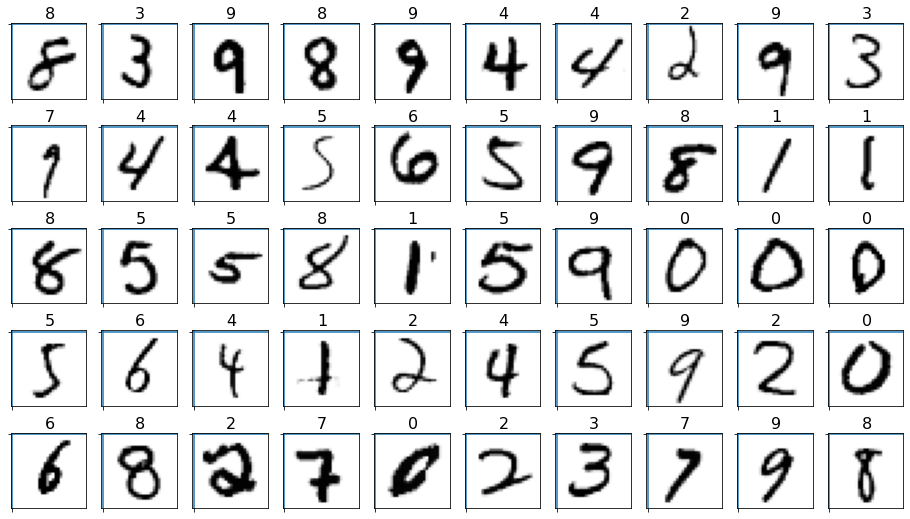

In [9]:
%matplotlib inline

count = 0
sample_size = 50
cols = 10
rows = math.ceil(sample_size / cols)
plt.figure(figsize=(16, rows))
plt.subplots_adjust(top=1.5)
for i in np.random.permutation(x_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(rows, cols, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=12, y=-2, s=y_train[i][0], fontsize=16)
    plt.imshow(x_train[i].reshape(28,28), cmap=plt.cm.Greys)
plt.show()


Next, we convert the N-Dimensional Arrays to a TensorFlow Dataset. We create a method to generate the dataset since the batch size of the dataset is what we are testing. The test data does not need shuffled, so we accept a parameter for the data's purpose.

In [10]:
def get_dataset_from_values(data, labels, batch_size=32, train=True):
    dataset = tf.data.Dataset.from_tensor_slices((data, labels)).batch(batch_size)
    if train:
        dataset = dataset.shuffle(10000)
    return dataset

In [11]:
test_ds = get_dataset_from_values(x_test, y_test, train=False)

Our last bit of data setup is to create a model-generating function. We need a new model for each experiment, rather than continuing to train the same model with different values.

In [12]:
def get_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation=tf.nn.relu),
        tf.keras.layers.Dense(256, activation=tf.nn.relu),
        tf.keras.layers.Dense(10)
    ])
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    optimizer = tf.keras.optimizers.Adam()

    model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])
    return model

We need to create a place to keep track of our experiments. Since we're working with MNIST, we'll call it "mnist".

**Note:** As of the time of writing, Experiments can't be deleted. They can be archived, which hides them from the UI, but the results are currently permanent within the Machine Learning Workspace. If you are developing new code, you should either use a separate development Machine Learning Workspace (a reasonable practice either way) or use an experiment name that you don't care to lose, such as appending a timestamp or random characters to the end ("mnist-ofj23").

In [13]:
from azureml.core import Experiment
experiment = Experiment(workspace=ws, name="mnist")

It's time to start the experiment!

We'll try doubling our batch_sizes in multiples of 16 to see if the larger values have any affect.

In [15]:
batch_size = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

for size in batch_size:
    run = experiment.start_logging()
    run.log("batch_size", size)
    
    #Create a new model and batch our training data with the current experiment size.
    model = get_model()
    traindata = get_dataset_from_values(x_train, y_train, batch_size = size)
    
    #Train the model
    model.fit(traindata, epochs=5)
    
    #Evaluate the model
    loss, acc = model.evaluate(test_ds)
    
    #Add the loss and accuracy information to the experiment for viewing later
    run.log("loss", float('%.3f' % loss))
    run.log("accuracy", float('%.3f' % (acc * 100)))
        
    run.complete()

Train for 3750 steps
Epoch 1/5
3750/3750 [==============================] - 9s 2ms/step - loss: 0.1899 - sparse_categorical_accuracy: 0.9421
Epoch 2/5
3750/3750 [==============================] - 8s 2ms/step - loss: 0.0897 - sparse_categorical_accuracy: 0.9725
Epoch 3/5
3750/3750 [==============================] - 8s 2ms/step - loss: 0.0622 - sparse_categorical_accuracy: 0.9802
Epoch 4/5
3750/3750 [==============================] - 8s 2ms/step - loss: 0.0481 - sparse_categorical_accuracy: 0.9844
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.0864 - sparse_categorical_accuracy: 0.9777
Train for 1875 steps
Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2014 - sparse_categorical_accuracy: 0.9388
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0844 - sparse_categorical_accuracy: 0.9741
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0587 - sparse_categorical_accuracy: 0.9820


View the results of your experiments in Azure Machine Learning Studio!

In [16]:
experiment

Name,Workspace,Report Page,Docs Page
mnist,javedml,Link to Azure Machine Learning studio,Link to Documentation
